## Batalla de los Vecindarios

### Introducción

En este documento se van a plantear diferentes aspectos a tener en cuenta a la hora de escoger el sitio ideal para una cafetería en la ciudad de Toronto. Se analizarán los diferentes vecindarios de Toronto en busca de información cómo número de cafeterías en la zona, densidad de población, … que sirvan como apoyo para tomar estas decisiones. El objetivo del proyecto es identificar que vecindarios donde abrir una cafetería podría tener mayor potencial de éxito, lo que implica buscar áreas con alta afluencia de personas, pero con pocas cafeterías existentes. Un análisis de este tipo es valioso para empresas y emprendedores permitiéndoles minimizar la competencia y maximizar la visibilidad y clientela potencial.

##### Importación de librerías

In [59]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # Librería para recuperar longitudes y latitudes

##### Variables globales

In [31]:
#Variables Globales
# - variables de foursquare
with open('apikey.txt', 'r') as f:
    API_KEY = f.read()


CITY_COORDS = '40.7128,-74.0060'  # Ejemplo: coordenadas para Nueva York
RADIUS = 15000  # Radio en metros
QUERY = 'coffee shop'
LIMIT = 50  # Número máximo de resultados

##### Cargamos las coordenadas de Toronto, lo que permite tener un punto clave para después pintar los datos en el mapa

In [32]:
address = 'Toronto'
geolocation = Nominatim(user_agent = 'CA_explorer')
location = geolocation.geocode(address)
location =np.array(location, dtype=object)
location[1]
log = str(location[1]).split(',')[1].replace(')','')
lat =  str(location[1]).split(',')[0].replace('(','')
print('(' + lat + ',' + log + ')')

(43.6534817, -79.3839347)


##### Cargamos los datos de los vecindarios de Toronto de wikipedia

In [33]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M") #get Canada data From wikipedia
df = df[0]
df = df.melt()['value']
df.head()

0                                      M1ANot assigned
1                      M1BScarborough(Malvern / Rouge)
2    M1CScarborough(Rouge Hill / Port Union / Highl...
3    M1EScarborough(Guildwood / Morningside / West ...
4                               M1GScarborough(Woburn)
Name: value, dtype: object

#####  Tratamos los datos recogido para que resulten manejables 

In [34]:
#Recorremos los datos descargados y extraemos los valores de "códigoPostal", "Vecindario" y "Municipio" de los strings 
df_clean = pd.DataFrame()
df_clean['CódigoPostal'] = df.apply(lambda x : x[:3])
df_clean['location_tmp'] = df.apply(lambda x : x[3:])

##### Borramos las filas que tienen municipio "no asignado"

In [35]:
df_clean = df_clean[df_clean['location_tmp'] != 'Not assigned']

In [36]:
#extraemos el municipio del campo localización temporal
df_clean['Municipio'] = df_clean['location_tmp'].apply(lambda x: str(x).split('(')[0])

In [37]:
#extraemos el Vecindario del campo localización temporal
df_clean['Vecindario'] = df_clean['location_tmp'].apply(lambda x: str(x).split('(')[1].replace(')', '').replace('/', ',') if '(' in str(x) and ')' in str(x) else None)

In [38]:
#si el Vecindario está como "No asignado", pero tiene municipio asignado se emplea el valor del Municipio como Vecindario
df_clean['Vecindario'] = np.where(df_clean['Vecindario'] == 'Not assigned', df_clean['Municipio'], df_clean['Vecindario'])
df_clean=df_clean[['CódigoPostal','Municipio', 'Vecindario']].reset_index(drop=True)

In [39]:
## Utilizamos el csv de coordendas para mapear los FSAs con sus coordenadas
city_data = pd.read_csv('Geospatial_Coordinates.csv')
city_data = city_data.rename(columns = {'Postal Code' : 'CódigoPostal'})
city_data

,CódigoPostal,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [40]:
df_clean = pd.merge(df_clean,city_data, on='CódigoPostal', how='inner')

In [41]:
#método que dadas unas coordenadas y un código postal, recupera el numero del cafeterías que se encuentrar en el mismo barrio
def getLocationData(neighborhood, postal_code):
    # Headers y parámetros para la solicitud
    headers = {
        "Accept": "application/json",
        "Authorization": API_KEY
    }
    params = {
        "ll": neighborhood, #'40.7128,-74.0060'
        "radius": RADIUS,
        "query": QUERY,
        "limit": LIMIT
    }

    # Llamada a la API de Foursquare Places v3
    url = "https://api.foursquare.com/v3/places/search"
    response = requests.get(url, headers=headers, params=params)

    # Verifica que la respuesta sea exitosa
    if response.status_code == 200:
        data = response.json()
        # Procesa y organiza los datos de los lugares
        cafeterias = []
        for place in data['results']:
            cafeterias.append({
                'Nombre': place['name'],
                'Latitud': place['geocodes']['main']['latitude'],
                'Longitud': place['geocodes']['main']['longitude'],
                'Dirección': place['location'].get('formatted_address', 'No especificado'),
                'Vecindario': place['location'].get('neighborhood', ['No especificado'])[0]
            })

        # Crear un DataFrame con los datos obtenidos
        df_cafeterias = pd.DataFrame(cafeterias)
        ## Filtramos que coincida el código postal
        df_cafeterias['CódigoPostal'] = df_cafeterias['Dirección'].apply(lambda x : x[-7:-4])
        df_cafeterias = df_cafeterias[df_cafeterias['CódigoPostal'] == postal_code]
        return df_cafeterias
    else:
        print("Error en la solicitud:", response.status_code, response.text)
        print("datos:" +  postal_code)
        return []

In [42]:
#método para recuperar lugares de interés de un vecindario
def getPuntosInteres(neighbothood, postal_code):
    # Headers y parámetros para la solicitud
    headers = {
        "Accept": "application/json",
        "Authorization": API_KEY
    }
    params = {
        "ll": neighborhood, #'40.7128,-74.0060'
        "radius": RADIUS,
        "query": 'places of interest',
        "limit": LIMIT
    }

    # Llamada a la API de Foursquare Places v3
    url = "https://api.foursquare.com/v3/places/search"
    response = requests.get(url, headers=headers, params=params)

    # Verifica que la respuesta sea exitosa
    if response.status_code == 200:
        data = response.json()
        # Procesa y organiza los datos de los lugares
        lInteres = []
        for place in data['results']:
            lInteres.append({
                'Nombre': place['name'],
                'Latitud': place['geocodes']['main']['latitude'],
                'Longitud': place['geocodes']['main']['longitude'],
                'Dirección': place['location'].get('formatted_address', 'No especificado'),
                'Vecindario': place['location'].get('neighborhood', ['No especificado'])[0]
            })

        # Crear un DataFrame con los datos obtenidos
        lInteres = pd.DataFrame(lInteres)
        ## Filtramos que coincida el código postal
        lInteres['CódigoPostal'] = lInteres['Dirección'].apply(lambda x : x[-7:-4])
        lInteres = lInteres[lInteres['CódigoPostal'] == postal_code]
        return lInteres
    else:
        print("Error en la solicitud:", response.status_code, response.text)
        print("datos:" +  postal_code)
        return []

##### Utilizando los métodos definidos para recuperar cafeterías y lugares de interés, recuperaremos el listado de lugares de interes y cafeterías por FSA

In [43]:
df_cafeterias = pd.DataFrame()
df_interes = pd.DataFrame()
for i in range(len(df_clean)):
    neighborhood = str(df_clean['Latitude'][i]) +',' + str(df_clean['Longitude'][i])
    data = getLocationData(neighborhood, df_clean['CódigoPostal'][i])
    interesdata = getPuntosInteres(neighborhood, df_clean['CódigoPostal'][i])
    if (len(data)):
        df_cafeterias = pd.concat([df_cafeterias, data])
        df_clean['cafeterias'] = len(data)
    else:
        df_clean['cafeterias'] = 0
    
    if (len(interesdata)):
        df_interes = pd.concat([df_interes, interesdata])
        df_clean['PInteres'] = len(interesdata)
    else:
        df_clean['PInteres'] = 0

In [44]:
df_cafeterias 

,Nombre,Latitud,Longitud,Dirección,Vecindario,CódigoPostal
18,Starbucks,43.797468,-79.149080,"6714 Kingston Rd (at Rylander Blvd.), Toronto ...",No especificado,M1B
24,Lamanna's Bakery,43.797847,-79.148482,"6758 Kingston Rd (at Sheppard Ave. E), Scarbor...",No especificado,M1B
11,Starbucks,43.783791,-79.187612,"1265 Military Trl, Toronto ON M1C 1A4",No especificado,M1C
22,Mr Beans Coffee Co,43.779710,-79.137108,"5550 Lawrence Ave E (at Port Union Rd), Scarbo...",No especificado,M1C
34,Ted's Restaurant,43.784474,-79.169201,"404 Old Kingston Rd, Scarborough ON M1C 1B6",No especificado,M1C
...,...,...,...,...,...,...
45,Starbucks,43.613377,-79.557959,"25 the West Mall (25 The West Mall), Etobicoke...",No especificado,M9C
48,Aroma Espresso Bar,43.612082,-79.558776,"25 the West Mall (The Queensway), Etobicoke ON...",No especificado,M9C
9,Tim Hortons,43.714722,-79.593700,"116 Queens Plate Dr, Etobicoke ON M9W 0B4",No especificado,M9W
15,Tim Hortons,43.713210,-79.580015,"285 Rexdale Blvd, Etobicoke ON M9W 1P7",No especificado,M9W


In [45]:
df_interes

,Nombre,Latitud,Longitud,Dirección,Vecindario,CódigoPostal
0,Dialogue of Faith Church of Canada,43.805399,-79.195185,"87 Thornmount Dr, Scarborough ON M1B 5S5",No especificado,M1B
1,BMO Bank of Montreal,43.803143,-79.193710,"8301 Sheppard Ave E, Scarborough ON M1B 5P7",No especificado,M1B
2,General Conference of Seventh-Day Adventists,43.802894,-79.194046,"65 Grand Marshall Dr, Scarborough ON M1B 5N6",No especificado,M1B
3,House of Prayer Community Church,43.804691,-79.200422,"1305 Morningside Ave, Scarborough ON M1B 4Z5",No especificado,M1B
4,King of Cosmetics & Perfumes,43.802540,-79.198259,"8130 Sheppard Ave E, Scarborough ON M1B 3W3",No especificado,M1B
...,...,...,...,...,...,...
39,Sringeri Temple of Toronto,43.719936,-79.574185,"80 Brydon Dr, Etobicoke ON M9W 4N6",No especificado,M9W
40,Machinery Canada Div of Turret Lathe Services Ltd,43.695258,-79.572117,"963 Martin Grove Rd, Etobicoke ON M9W 4V6",No especificado,M9W
41,Refuge Temple Church of the First Born,43.719644,-79.573575,"76 Brydon Dr, Etobicoke ON M9W 4N6",No especificado,M9W
43,Al-Azhar Academy of Canada,43.714804,-79.569132,"2074 Kipling Ave, Etobicoke ON M9W 4J9",No especificado,M9W


##### Emplenado los datos censales de los ciudadanos de toronto, recuperaremos la población por código postal

In [46]:
df_densidades = pd.read_csv('datos-censales-canada.csv', sep=';')
df_densidades = df_densidades[['Population and dwelling counts (3)', 'Population, 2021']]
df_densidades

,Population and dwelling counts (3),"Population, 2021"
0,A0A,"44,93"
1,A0B,"19,287"
2,A0C,"11,972"
3,A0E,"21,209"
4,A0G,"33,316"
...,...,...
1662,NaN,NaN
1663,NaN,NaN
1664,NaN,NaN
1665,How to cite: Statistics Canada. Table 98-10-00...,NaN


##### Limpiamos los datos de densidades y preparamos los datos de número de cafeterías y lugares de interés por FSA.

In [47]:
# Borrado de nulos
df_densidades = df_densidades.dropna()
df_densidades.columns = ['CódigoPostal' , 'población']

#agrupamiento de los lugares de interés y cafeterías por código postal
conteo_lugares = df_interes.groupby('CódigoPostal').size().reset_index(name='num_lugares_interes')
conteo_cafeterias = df_cafeterias.groupby('CódigoPostal').size().reset_index(name='num_cafeterias')

##### Con todos los datos de entrada listos, vamos a mergear los dataframes para poder continuar con el análisis

In [48]:
df_final = df_clean[['CódigoPostal', 'Municipio', 'Vecindario', 'Latitude', 'Longitude']].merge(df_densidades, on='CódigoPostal', how='left')
df_final = df_final.merge(conteo_lugares, on='CódigoPostal', how='left')
df_final = df_final.merge(conteo_cafeterias, on='CódigoPostal', how='left')
df_final['num_lugares_interes'] = df_final['num_lugares_interes'].fillna(0).astype(int)
df_final['num_cafeterias'] = df_final['num_cafeterias'].fillna(0).astype(int)

In [49]:
#transformamos el número de habitantes para poder trabajarlo correctamente
df_final['población'] = df_final['población'].astype(str).str.replace(',', '').str.replace('nan', '0').astype(int)

#dado que nos interesan aquellas zonas que menos cafeterías tengan para minimizar la competencia,
# vamos a 'invertir' el valor del número de cafeterías, de modo que se valorará positivamente aquellas regiones con menor número de cafeterías
df_final['cafeterias_invertidas'] = df_final['num_cafeterias'].max() - df_final['num_cafeterias']

##### A continuación, sigue el proceso de clustering para puntuar y valorar las regiones 'más aptas' para nuestra cafetería

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import folium
import matplotlib
from folium import CircleMarker


In [51]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_final[['población', 'num_lugares_interes', 'cafeterias_invertidas']])
df_final[['densidad_norm', 'interes_norm', 'competencia_norm']] = scaled

df_final['puntuacion'] = (
    0.4 * df_final['densidad_norm'] +
    0.2 * df_final['interes_norm'] +
    0.4 * df_final['competencia_norm']
)

In [52]:
features = df_final[['densidad_norm', 'interes_norm', 'competencia_norm']]
kmeans = KMeans(n_clusters=5, random_state=0)
df_final['cluster'] = kmeans.fit_predict(features)

In [53]:
resumen = df_final.groupby('cluster')[['población', 'num_cafeterias', 'num_lugares_interes']].mean()
print(resumen)

# Supongamos que cluster 2 es el mejor: (suposición, solo para ver los resultados)
mejores_zonas = df_final[df_final['cluster'] == 2].sort_values('puntuacion', ascending=False)
print(mejores_zonas[['CódigoPostal', 'puntuacion']].head())

            población  num_cafeterias  num_lugares_interes
cluster                                                   
0        10001.280000        0.720000            27.200000
1        10288.791667        0.291667             7.791667
2        46695.928571        1.428571            33.357143
3        30281.818182        0.181818            19.909091
4        32903.714286        4.428571            24.428571
    CódigoPostal  puntuacion
18           M2J    0.968517
101          M9V    0.866250
27           M3C    0.820893
0            M1B    0.810714
6            M1K    0.806452


In [54]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred']

# Crear mapa centrado en Toronto
mapa = folium.Map(location=[43.7, -79.4], zoom_start=10)

# Añadir marcadores
for _, row in df_final.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color=colors[row['cluster'] % len(colors)],
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"FSA: {row['CódigoPostal']}<br>"
            f"Cluster: {row['cluster']}<br>"
            f"Puntuación: {row['puntuacion']:.2f}<br>"
            f"Densidad: {row['población']}<br>"
            f"Cafeterías: {row['num_cafeterias']}<br>"
            f"Lugares de interés: {row['num_lugares_interes']}"
        )
    ).add_to(mapa)

mapa

In [55]:
df_final.groupby('cluster')[['población', 'num_cafeterias', 'num_lugares_interes', 'puntuacion']].mean()

,población,num_cafeterias,num_lugares_interes,puntuacion
cluster,,,,
0,10001.280000,0.720000,27.200000,0.533216
1,10288.791667,0.291667,7.791667,0.478578
2,46695.928571,1.428571,33.357143,0.742282
3,30281.818182,0.181818,19.909091,0.657337
4,32903.714286,4.428571,24.428571,0.449495


In [56]:
#Analizando los datos de los 5 diferentes clusters aparentemente los mejores clusters serían el cluster 2 y el cluster 3.
mejores_zonas_cluster2 = df_final[df_final['cluster'] == 2].sort_values('puntuacion', ascending=False)
print(mejores_zonas_cluster2[['CódigoPostal', 'puntuacion']].head())

    CódigoPostal  puntuacion
18           M2J    0.968517
101          M9V    0.866250
27           M3C    0.820893
0            M1B    0.810714
6            M1K    0.806452


In [57]:
mejor_zona = mejores_zonas_cluster2.sort_values('puntuacion', ascending=False).head(1)
print(mejor_zona)

   CódigoPostal   Municipio                      Vecindario   Latitude  \
18          M2J  North York  Fairview , Henry Farm , Oriole  43.778517   

    Longitude  población  num_lugares_interes  num_cafeterias  \
18 -79.346556      61761                   46               0   

    cafeterias_invertidas  densidad_norm  interes_norm  competencia_norm  \
18                      7       0.942125      0.958333               1.0   

    puntuacion  cluster  
18    0.968517        2  


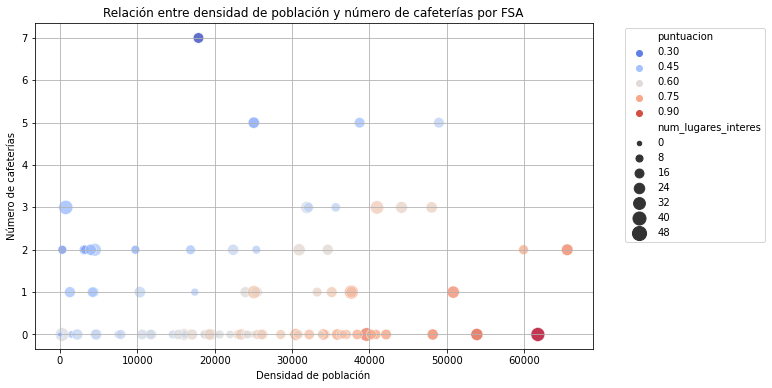

In [61]:
# Densidad vs. número de cafeterías
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_final,
    x='población',
    y='num_cafeterias',
    hue='puntuacion',
    palette='coolwarm',
    size='num_lugares_interes',
    sizes=(20, 200),
    alpha=0.8
)
plt.title('Relación entre densidad de población y número de cafeterías por FSA')
plt.xlabel('Densidad de población')
plt.ylabel('Número de cafeterías')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



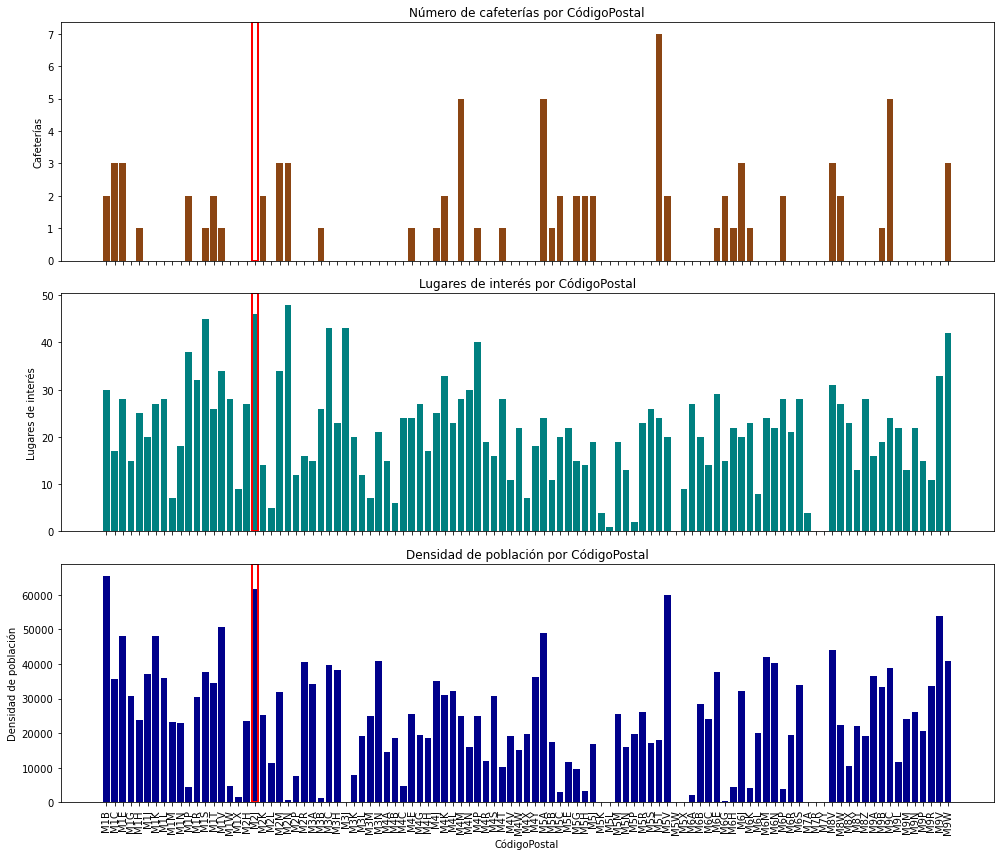

In [62]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Ordenar por Código Postal
df_plot = df_final.sort_values('CódigoPostal')

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Datos comunes
x_labels = df_plot['CódigoPostal']
x = list(range(len(x_labels)))  # posición de cada barra
m2j_index = df_plot[df_plot['CódigoPostal'] == 'M2J'].index[0]  # índice real en df
m2j_pos = df_plot.index.get_loc(m2j_index)  # posición dentro del gráfico

# Gráfico 1: Cafeterías
axes[0].bar(x, df_plot['num_cafeterias'], color='saddlebrown')
axes[0].set_title('Número de cafeterías por CódigoPostal')
axes[0].set_ylabel('Cafeterías')

# Gráfico 2: Lugares de interés
axes[1].bar(x, df_plot['num_lugares_interes'], color='teal')
axes[1].set_title('Lugares de interés por CódigoPostal')
axes[1].set_ylabel('Lugares de interés')

# Gráfico 3: Población
axes[2].bar(x, df_plot['población'], color='darkblue')
axes[2].set_title('Densidad de población por CódigoPostal')
axes[2].set_ylabel('Densidad de población')
axes[2].set_xlabel('CódigoPostal')

# Agregar rectángulo rojo en la posición de "M2J"
for ax in axes:
    # Coordenadas del recuadro: x, y, ancho, alto
    rect = Rectangle(
        (m2j_pos - 0.4, 0),  # x empieza a la izquierda de la barra
        width=0.8,           # ancho de la barra
        height=ax.get_ylim()[1],  # altura total del eje Y
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

# Etiquetas y presentación
plt.xticks(ticks=x, labels=x_labels, rotation=90)
plt.tight_layout()
plt.show()


In [65]:
# Crear una columna de puntuación (alta densidad y pocas cafeterías)
df_final['score'] = df_final['población'] / (df_final['num_cafeterias'] + 1)  # +1 para evitar división por cero

# Seleccionar los 10 mejores FSAs según el score
top_fsa = df_final.sort_values('score', ascending=False).head(10)

# Extraer columnas necesarias y ordenar alfabéticamente
df_plot = top_fsa[['CódigoPostal', 'num_cafeterias', 'num_lugares_interes', 'población']].sort_values('CódigoPostal')

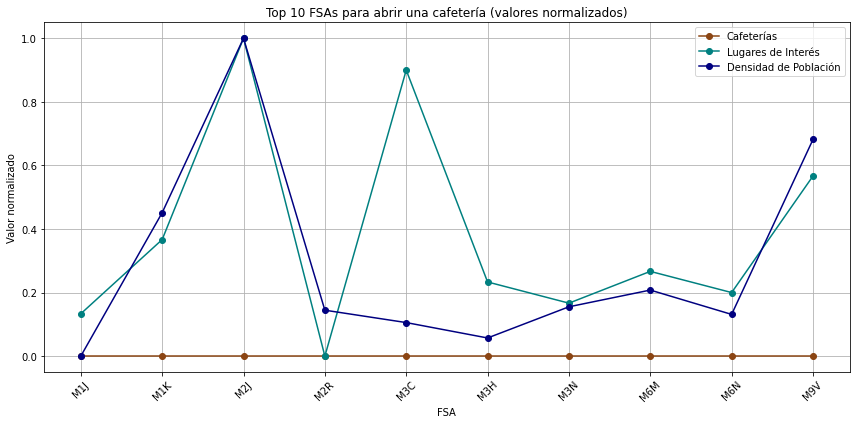

In [70]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Normalizamos
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_plot[['num_cafeterias', 'num_lugares_interes', 'población']])
df_normalized = pd.DataFrame(normalized_data, columns=['Cafeterías', 'Lugares de Interés', 'Densidad de Población'])
df_normalized['FSA'] = df_plot['CódigoPostal'].values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_normalized['FSA'], df_normalized['Cafeterías'], marker='o', label='Cafeterías', color='saddlebrown')
plt.plot(df_normalized['FSA'], df_normalized['Lugares de Interés'], marker='o', label='Lugares de Interés', color='teal')
plt.plot(df_normalized['FSA'], df_normalized['Densidad de Población'], marker='o', label='Densidad de Población', color='navy')

plt.title('Top 10 FSAs para abrir una cafetería (valores normalizados)')
plt.xlabel('FSA')
plt.ylabel('Valor normalizado')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [73]:
#check datos
top_fsa[['CódigoPostal', 'num_cafeterias', 'num_lugares_interes', 'población', 'puntuacion', 'cluster']].sort_values(by='num_cafeterias')

,CódigoPostal,num_cafeterias,num_lugares_interes,población,puntuacion,cluster
18,M2J,0,46,61761,0.968517,2
101,M9V,0,33,53878,0.866250,2
6,M1K,0,27,48175,0.806452,2
80,M6M,0,24,42148,0.757176,3
33,M3N,0,21,40846,0.736732,3
24,M2R,0,16,40581,0.714282,3
81,M6N,0,22,40252,0.737274,3
27,M3C,0,43,39616,0.820893,2
28,M3H,0,23,38416,0.730238,3
5,M1J,0,20,37002,0.709110,3


In [68]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'notebook_connected'  # o prueba 'notebook_connected'

# Crear dataframe si no está ya cargado
# df_final = ...

# Construir DataFrame largo (para comparar varias métricas en un solo gráfico)
df_long = pd.melt(
    df_final,
    id_vars=['CódigoPostal', 'población'],
    value_vars=['num_cafeterias', 'num_lugares_interes'],
    var_name='Tipo',
    value_name='Cantidad'
)
# Gráfico interactivo
fig = px.scatter(
    df_long,
    x='población',
    y='Cantidad',
    color='Tipo',
    hover_name='CódigoPostal',
    symbol='Tipo',
    title='Densidad de población vs. Cantidad de cafeterías y lugares de interés',
    labels={
        'población': 'Densidad de población',
        'Cantidad': 'Cantidad',
        'Tipo': 'Tipo de lugar'
    }
)

fig.update_layout(
    legend_title_text='Categoría',
    hovermode='closest'
)

fig.show()
